In [1]:
import torch
import torchvision
import PIL
import os
from matplotlib import pyplot as plt
import cv2
import random
import warnings
import timm
from torch import nn
import numpy as np
from tqdm import tqdm_notebook
from torchvision.models import mobilenet_v3_small
from torchsummary import summary
import glob

import seaborn as sb
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


warnings.filterwarnings('ignore')

device='cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using: {device}')


Using: cuda


In [2]:
model=mobilenet_v3_small(weights='DEFAULT')
model.classifier[3]=nn.Linear(in_features=1024,out_features=2,bias=True)

In [3]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [4]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,src=None,paths=None):
        if src is not None:
            self.src=src
            self.images=os.listdir(src)
            
        else:
            self.src=None
            self.images=paths

        self.transforms=torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()
    
    def __len__(self):
        return len(self.images)

    def random_float(self,min_val, max_val, decimal_places):
        return round(random.uniform(min_val, max_val), decimal_places)


    def __getitem__(self,idx):
        if self.src is not None:
            img=cv2.imread(self.src+"/"+self.images[idx])
        else:
            img=cv2.imread(self.images[idx])
          
        height, width = img.shape[:2]

        x = (width - 1920) // 2
        y = (height - 1080) // 2
        
        img = img[y:y+1080, x:x+1920]

        downsize=random.randint(0,1)

        if(downsize):
                image=img
                
                original_height, original_width = image.shape[:2]

                scale_factor =  self.random_float(1.5, 4, 2)


                new_width = int(original_width // scale_factor)
                new_height = int(original_height // scale_factor)  
                
                downscaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
            
                upscaled_image = torch.from_numpy(cv2.resize(downscaled_image, (original_width, original_height), interpolation=cv2.INTER_NEAREST)).permute(2,0,1)

                return self.transforms(upscaled_image), torch.tensor([0,1]).type(torch.float32)
                          
        else:
                return self.transforms(torch.from_numpy(img).permute(2,0,1)),torch.tensor([1,0]).type(torch.float32)
        

In [5]:
path='../../../Flickr2K/'
paths = glob.glob(path + "/*.png")

np.random.seed(123)
paths_subset = np.random.choice(paths, 2_484, replace=False) 
rand_idxs = np.random.permutation(2_484)
train_idxs = rand_idxs[:2000] 
val_idxs = rand_idxs[2000:2200] 
test_idxs = rand_idxs[2200:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
test_paths = paths_subset[test_idxs]

In [6]:
train_ds=dataset(paths=train_paths)
val_ds=dataset(paths=val_paths)
test_ds=dataset(paths=test_paths)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.FloatTensor
tensor([1., 0.])


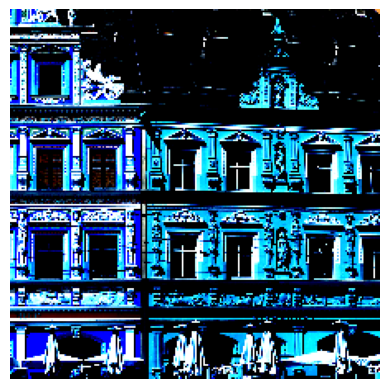

In [7]:
plt.axis(False)
t=train_ds.__getitem__(torch.randint(0,1000,(1,)))
print(t[0].shape)
print(t[0].type())
plt.imshow(t[0].permute(1,2,0))
print(t[1])

In [8]:
torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
train_loader=torch.utils.data.DataLoader(train_ds,16,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_ds,16,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_ds,16,shuffle=True)

In [10]:
x,y=next(iter(train_loader))

In [11]:
x,y=next(iter(train_loader))
print(x.shape)
output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
output

torch.Size([16, 3, 224, 224])


tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0])

In [12]:
y

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])

In [13]:
loss_fn=nn.CrossEntropyLoss()

In [14]:
with torch.inference_mode():
    logits=model(x)
    torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),torch.argmax(y,dim=1)).sum().item()/len(logits)
    print(loss_fn(torch.squeeze(logits,dim=1),y))

tensor(0.7260)


In [15]:
model=model.to(device)

In [16]:
def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)

def train_model(model,epochs):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.CrossEntropyLoss()
    
    max_acc=0
    for i in tqdm_notebook(range(epochs)):
        train_preds=torch.tensor([])
        val_preds=torch.tensor([])
        train_actual=torch.tensor([])
        val_actual=torch.tensor([])
        
        print("\nTraining:")
        model.train()
        
        #Defining accuracy and loss for train and val data
        temp_train_accuracy=[]
        temp_val_accuracy=[]
        temp_train_loss=[]
        temp_val_loss=[]
      
        net_train_accuracy=0
        net_val_accuracy=0
        net_train_loss=0
        net_val_loss=0
        
        with tqdm_notebook(total=len(train_loader)) as pbar:
            for x,y in train_loader:
                    x=x.to(device)
                    y=y.to(device)
        
                    #Calculating model output
                    logits=model(x)
        
                    #Reseting any old gradient values
                    optimizer.zero_grad()
                    loss=loss_fn(torch.squeeze(logits,dim=1),y)
                
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    accuracy_train=accuracy_fn(logits.type(torch.float32),torch.argmax(y,dim=1))
                    temp_train_accuracy.append(accuracy_train)
                    temp_train_loss.append(loss.item())
                
                    #Back Propogation
                    loss.backward()
                
                    #Update Parameters
                    optimizer.step()
                
                    #Progress Bar Update
                    pbar.update(1)
            pbar.close()
        net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
        net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    
        #Evaluation
        print("Testing:")
        model.eval()

        
    
        with tqdm_notebook(total=len(val_loader)) as pbar2:
            for x,y in val_loader:
                x=x.to(device)
                y=y.to(device)
                
                #Setting inference mode
                with torch.inference_mode():
                    logits=model(x)
                    loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                    
                    #Track of metrics
                    preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                    accuracy_val=accuracy_fn(logits,torch.argmax(y,dim=1))
                    temp_val_accuracy.append(accuracy_val)
                    temp_val_loss.append(loss.item())
        
                    #Progress Bar Update
                    pbar2.update(1)
            pbar2.close()
    
        net_val_accuracy=sum(temp_val_accuracy)/len(temp_val_accuracy)
        net_val_loss=sum(temp_val_loss)/len(temp_val_loss)
     
        if(net_val_accuracy>max_acc):
            if(max_acc!=0):
                os.remove(f'method1({max_acc:.3f}).pt')
            max_acc=net_val_accuracy
            print(f'Saving model')
            torch.save(model.state_dict(),f'method1({net_val_accuracy:.3f}).pt')
        
        print(f"\nEpoch {i+1}:\n\nTrain Accuracy: {net_train_accuracy}\n\nTrain Loss: {net_train_loss}\n\nVal Accuracy: {net_val_accuracy}\n\nVal Loss: {net_val_loss}")


def test_model(model):
    optimizer=torch.optim.Adam(params=model.parameters())
    loss_fn=nn.CrossEntropyLoss()
    
    test_preds=torch.tensor([])
    test_actual=torch.tensor([])

    
    predictions=[]
    targets=[]
    
    temp_test_accuracy=[]
    temp_test_loss=[]

    net_test_accuracy=0
    net_test_loss=0

    #Evaluation
    print("Testing:")
    model.eval()

    

    with tqdm_notebook(total=len(test_loader)) as pbar2:
        for x,y in test_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(torch.squeeze(logits,dim=1),y.type(torch.float32))
                
                #Track of metrics
                preds=torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze()
                accuracy_test=accuracy_fn(logits,torch.argmax(y,dim=1))
                temp_test_accuracy.append(accuracy_test)
                temp_test_loss.append(loss.item())
                predictions.extend(torch.argmax(torch.softmax(logits,dim=1),dim=1).tolist())
                targets.extend(torch.argmax(y, dim=1).tolist())

                #Progress Bar Update
                pbar2.update(1)
                
                
        pbar2.close()

    

    conf_matrix = confusion_matrix(targets, predictions)

    # Calculate precision, recall, and F1 score
    precision = precision_score(targets, predictions)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    
    print("Confusion Matrix:")
    print("\nPrecision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    
    net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
    net_test_loss=sum(temp_test_loss)/len(temp_test_loss)

    print(f"Test Accuracy: {net_test_accuracy}\nTest Loss: {net_test_loss}")

    plt.figure(figsize=(10, 7))
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pixelated'], yticklabels=['Normal', 'Pixelated'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
train_model(model,20)

  0%|          | 0/20 [00:00<?, ?it/s]


Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]

Saving model

Epoch 1:

Train Accuracy: 0.5155

Train Loss: 0.7409324660301209

Val Accuracy: 0.5192307692307693

Val Loss: 0.8351430159348708

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]

Saving model

Epoch 2:

Train Accuracy: 0.529

Train Loss: 0.7194851622581482

Val Accuracy: 0.5673076923076923

Val Loss: 0.6926310154107901

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 3:

Train Accuracy: 0.5255

Train Loss: 0.7061710648536682

Val Accuracy: 0.5144230769230769

Val Loss: 0.7235024892366849

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]

Saving model

Epoch 4:

Train Accuracy: 0.552

Train Loss: 0.6996038684844971

Val Accuracy: 0.5769230769230769

Val Loss: 0.7328214278587928

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 5:

Train Accuracy: 0.5335

Train Loss: 0.7034169359207153

Val Accuracy: 0.5288461538461539

Val Loss: 0.7014399079176096

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 6:

Train Accuracy: 0.528

Train Loss: 0.6929675369262696

Val Accuracy: 0.47596153846153844

Val Loss: 0.7927065354127151

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 7:

Train Accuracy: 0.5465

Train Loss: 0.6973295345306396

Val Accuracy: 0.5336538461538461

Val Loss: 0.7262073617715102

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 8:

Train Accuracy: 0.544

Train Loss: 0.6927962555885315

Val Accuracy: 0.5673076923076923

Val Loss: 0.674576209141658

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 9:

Train Accuracy: 0.5755

Train Loss: 0.6795153417587281

Val Accuracy: 0.5625

Val Loss: 0.7647611544682429

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]

Saving model

Epoch 10:

Train Accuracy: 0.573

Train Loss: 0.6774495453834534

Val Accuracy: 0.6682692307692307

Val Loss: 0.6612744698157678

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 11:

Train Accuracy: 0.572

Train Loss: 0.6804435448646545

Val Accuracy: 0.5048076923076923

Val Loss: 0.7677414279717666

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 12:

Train Accuracy: 0.603

Train Loss: 0.669665456533432

Val Accuracy: 0.5576923076923077

Val Loss: 0.7019688120255103

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 13:

Train Accuracy: 0.59

Train Loss: 0.6720801842212677

Val Accuracy: 0.5384615384615384

Val Loss: 0.6886283617753249

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 14:

Train Accuracy: 0.629

Train Loss: 0.6545795278549195

Val Accuracy: 0.5288461538461539

Val Loss: 0.6946487976954534

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 15:

Train Accuracy: 0.6175

Train Loss: 0.6560339643955231

Val Accuracy: 0.5336538461538461

Val Loss: 0.7230540651541489

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 16:

Train Accuracy: 0.6345

Train Loss: 0.6446521859169007

Val Accuracy: 0.5240384615384616

Val Loss: 0.7172982142521784

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 17:

Train Accuracy: 0.622

Train Loss: 0.6454905474185944

Val Accuracy: 0.5528846153846154

Val Loss: 0.7611982661944169

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 18:

Train Accuracy: 0.647

Train Loss: 0.6332120451927185

Val Accuracy: 0.5817307692307693

Val Loss: 0.7062296500572791

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 19:

Train Accuracy: 0.643

Train Loss: 0.6303547840118409

Val Accuracy: 0.5432692307692307

Val Loss: 0.827359126164363

Training:


  0%|          | 0/125 [00:00<?, ?it/s]

Testing:


  0%|          | 0/13 [00:00<?, ?it/s]


Epoch 20:

Train Accuracy: 0.6695

Train Loss: 0.6249786059856415

Val Accuracy: 0.6105769230769231

Val Loss: 0.669297076188601


Testing:


  0%|          | 0/18 [00:00<?, ?it/s]

Confusion Matrix:

Precision: 0.5648148148148148
Recall: 0.4326241134751773
F1 Score: 0.4899598393574297
Test Accuracy: 0.5555555555555556
Test Loss: 0.6752162012788985


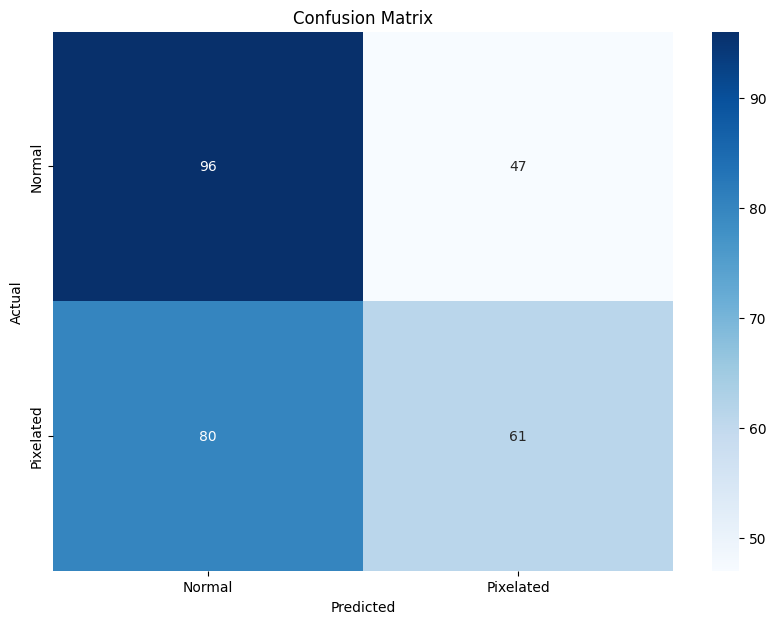

In [18]:
model.load_state_dict(torch.load('method1(0.668).pt'))
test_model(model)

In [19]:
x,y=next(iter(val_loader))
x=x.to(device)
y=y.to(device)

In [20]:
with torch.inference_mode():
    output=torch.argmax(torch.softmax(model(x),dim=1),dim=1)
    print(output)

tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')


In [21]:
torch.argmax(y,dim=1)

tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')

In [22]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 5.844MB
